In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from tabulate import tabulate
get_ipython().run_line_magic('matplotlib', 'inline')
from IPython.display import display, HTML

2024-01-27 16:23:10.444768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-27 16:23:10.623728: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-27 16:23:11.464010: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2024-01-27 16:23:11.464084: W tensorflow/compiler/xla/stream

In [2]:
df1 = pd.read_csv('/home/hanping/remote file/MFB/dataset/processed/text_grouped.csv')

In [3]:
df2 = pd.read_csv('/home/hanping/remote file/MFB/dataset/processed/btc_grouped.csv')

In [4]:
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)

df2['date'] = pd.to_datetime(df2['date'])
df2.set_index('date', inplace=True)

In [5]:
# merge the two dataframes
df_merged = pd.merge(df1, df2, on='date', how='inner')

df_merged = df_merged.sort_values('date')
df = df_merged

target_col = 'Close'
df.head()

,compound,Close,Stochastic,ADI,EMA,MACD,RSI,OBV,ATR
date,,,,,,,,,
2021-01-01 00:00:00,6.8806,28995.13,86.781857,1225550.420,28876.78754,133.534560,55.394904,535353.6668,378.718086
2021-01-01 01:00:00,15.9848,29409.99,96.295679,1229681.093,28947.88120,164.922849,62.207462,540756.7353,388.070365
2021-01-01 02:00:00,10.3930,29194.65,83.003086,1228327.545,28980.78371,170.457230,57.314228,538372.5037,385.010339
2021-01-01 03:00:00,3.4254,29278.40,85.898804,1228595.460,29020.46588,179.531664,58.675685,539833.8488,373.008172
2021-01-01 04:00:00,4.3995,29220.31,78.456428,1228685.879,29047.11176,179.961357,57.310301,537795.8020,372.479017


In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(df2, test_size=0.2)


In [8]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=1):
    fig, ax = plt.subplots(1, figsize=(12,5))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [BTC]', fontsize=16)
    ax.set_xlabel('Date', fontsize=16)
    plt.rcParams['axes.labelcolor'] = 'k'
    plt.rcParams['xtick.color'] = 'k'
    plt.rcParams['ytick.color'] = 'k'
    ax.tick_params(labelsize=11)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=11);


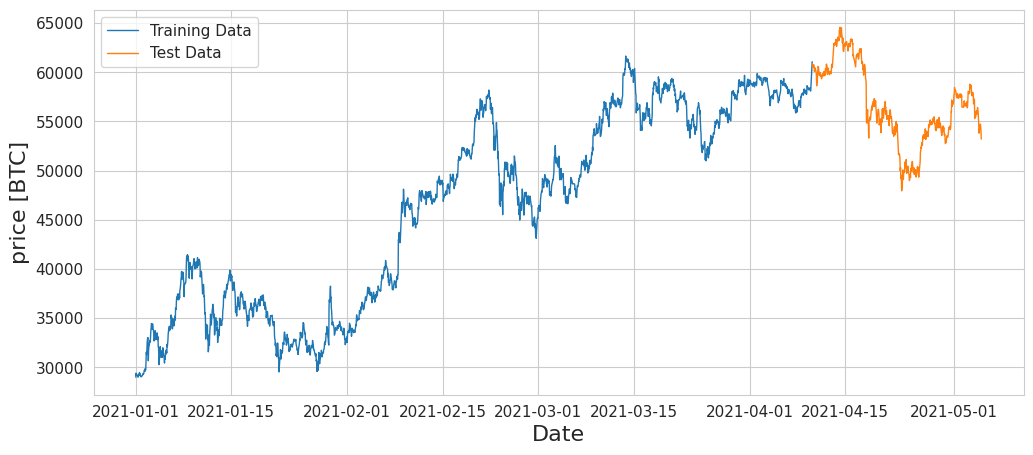

In [9]:
line_plot(train[target_col], test[target_col], 'Training Data', 'Test Data', title='')

In [10]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [11]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)


In [12]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


Building LSTM Model

In [13]:
def build_lstm_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1],input_data.shape[2])))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [14]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 256
epochs = 50
batch_size = 16
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


In [15]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [16]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

2024-01-27 16:23:14.469828: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64
2024-01-27 16:23:14.470411: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-01-27 16:23:14.470956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild Tens

Epoch 1/50
141/141 [==============================] - 4s 13ms/step - loss: 0.0134 - val_loss: 0.0011
Epoch 2/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 7.7159e-04
Epoch 3/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 8.7001e-04
Epoch 4/50
141/141 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 6.2120e-04
Epoch 5/50
141/141 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 6/50
141/141 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 2.2857e-04
Epoch 7/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 5.1433e-04
Epoch 8/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 4.1847e-04
Epoch 9/50
141/141 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 2.7742e-04
Epoch 10/50
141/141 [==============================] - 1s 8ms/step - lo

In [17]:
path='/home/hanping/remote file/MFB/prediction_result/'

In [18]:
# Save the model
model.save(path+'LSTM_model.h5')

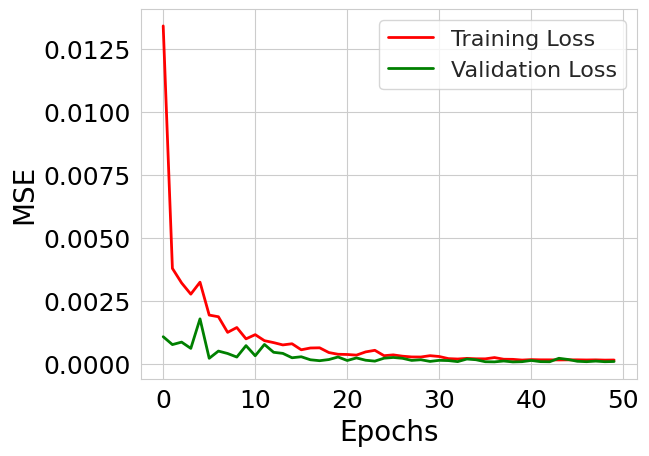

In [19]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=16)
plt.show()


In [20]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 1s 4ms/step


0.00672431046558848

In [21]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE

0.00010207274171282783

In [22]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6771009918080702

In [23]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse

0.010103105547940585

In [24]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)


2.464534347914494

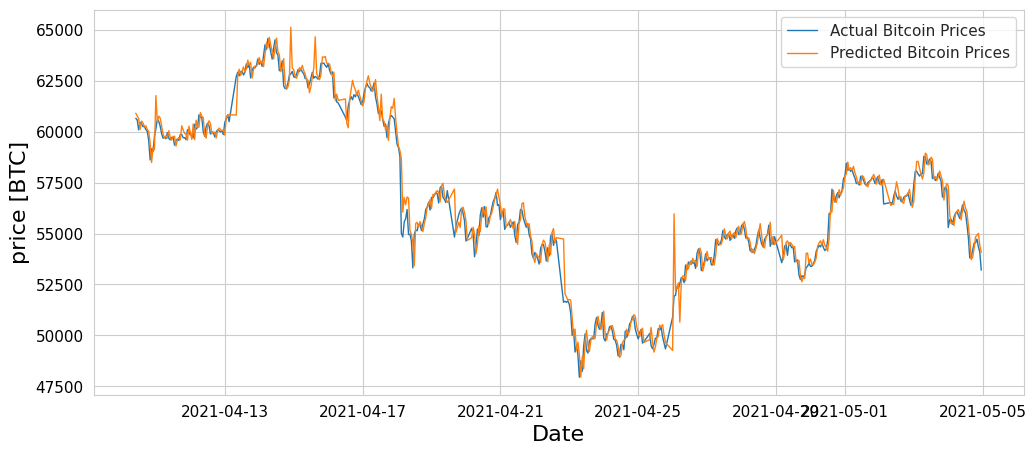

In [25]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=1)

In [26]:
model1_preds=preds

# GRU

In [27]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, GRU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
get_ipython().run_line_magic('matplotlib', 'inline')

In [28]:
#PRICE NORMALISATION

In [29]:
def build_gru_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [30]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
gru_neurons = 256
epochs = 50
batch_size = 16
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


In [31]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [32]:
model = build_gru_model(
    X_train, output_size=1, neurons=gru_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
141/141 [==============================] - 4s 12ms/step - loss: 0.0185 - val_loss: 0.0139
Epoch 2/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0164 - val_loss: 0.0023
Epoch 3/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0077 - val_loss: 0.0044
Epoch 4/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0083 - val_loss: 0.0013
Epoch 5/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0083 - val_loss: 0.0018
Epoch 6/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0071 - val_loss: 0.0010
Epoch 7/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 8/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 9/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0047 - val_loss: 6.6848e-04
Epoch 10/50
141/141 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0

In [33]:
# Save the model
model.save(path+'GRU_model.h5')

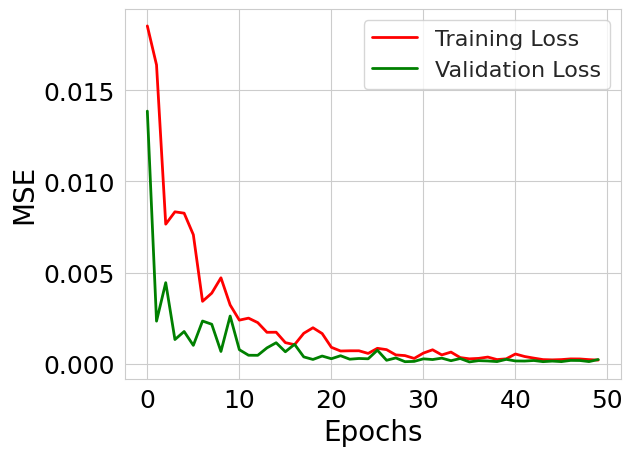

In [34]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=16)
plt.show()

In [35]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 0s 4ms/step


0.008215250208191225

In [36]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE


0.00022643419623924262

In [37]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse


0.015047730600965802

In [38]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2


0.2836934115859102

In [39]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)

3.563022559964728

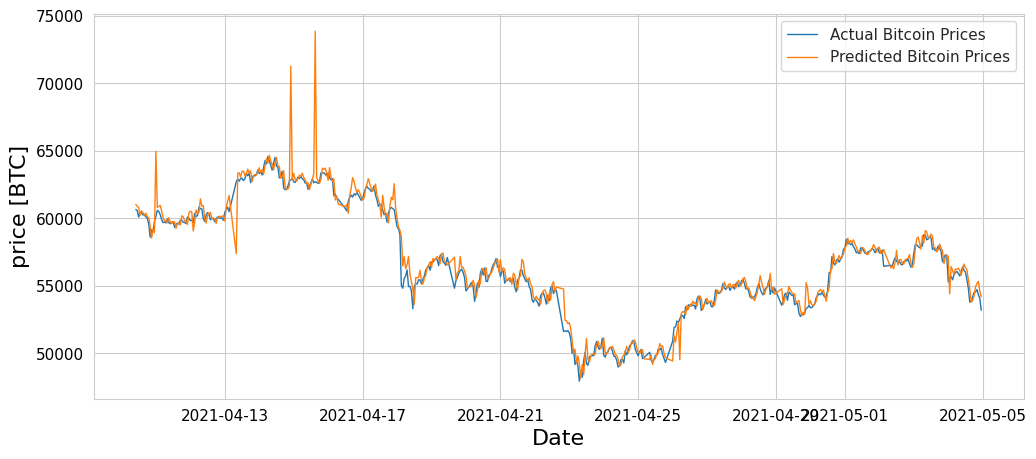

In [40]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=1)

In [41]:
model2_preds=preds

# BiLSTM

In [42]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, GRU
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
get_ipython().run_line_magic('matplotlib', 'inline')


In [43]:
def build_Bilstm_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]))))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [44]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 256
epochs = 50
batch_size = 8
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [45]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [46]:
model = build_Bilstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 7s 12ms/step - loss: 0.0144 - val_loss: 0.0024
Epoch 2/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0051 - val_loss: 0.0023
Epoch 3/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 4/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0031 - val_loss: 6.9892e-04
Epoch 5/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0025 - val_loss: 4.4269e-04
Epoch 6/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 7/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0017 - val_loss: 8.3168e-04
Epoch 8/50
281/281 [==============================] - 2s 9ms/step - loss: 0.0012 - val_loss: 4.9164e-04
Epoch 9/50
281/281 [==============================] - 2s 9ms/step - loss: 8.5717e-04 - val_loss: 0.0012
Epoch 10/50
281/281 [==============================] - 2s 9ms/step - loss: 0.00

In [47]:
# Save the model
model.save(path+'BiLSTM_model.h5')

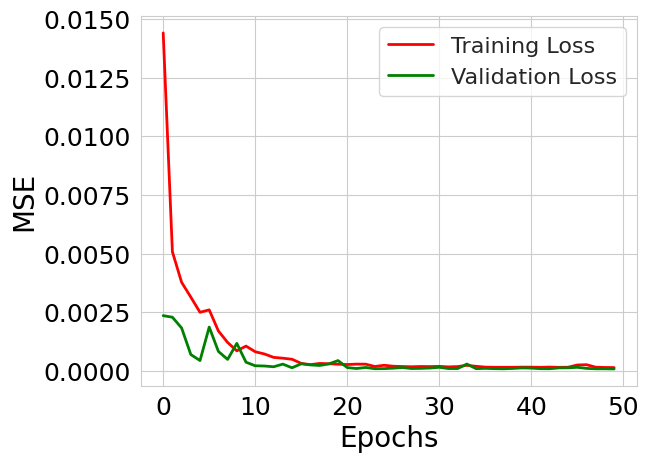

In [48]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=16)
plt.show()

In [49]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 1s 4ms/step


0.006277854426817258

In [50]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE


8.595313985387105e-05

In [51]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse


0.009271091621479698

In [52]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2


0.7280940715016648

In [53]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)

2.1732560074362564

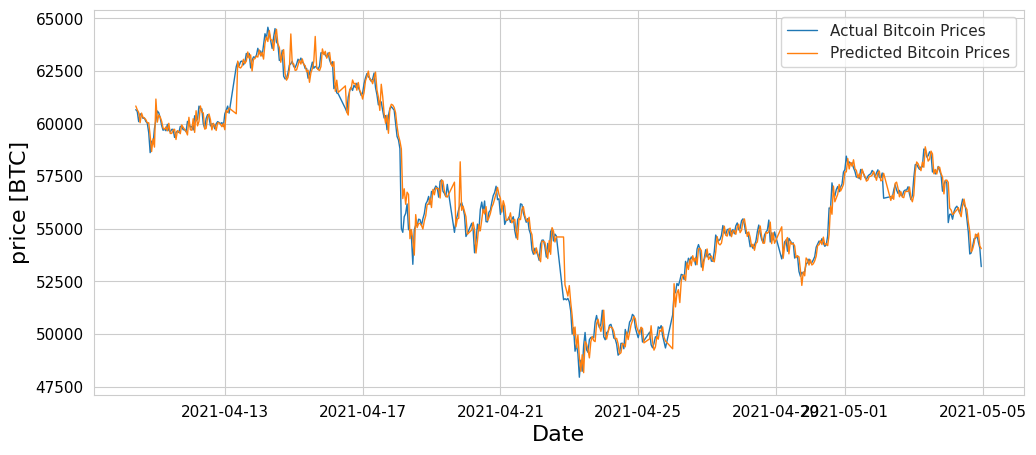

In [54]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=1)

In [55]:
model3_preds=preds

# BiGRU

In [56]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, GRU, BatchNormalization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
get_ipython().run_line_magic('matplotlib', 'inline')

In [57]:
def build_BiGRU_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(Bidirectional(GRU(neurons, input_shape=(input_data.shape[1], input_data.shape[2]))))
    model.add(Dropout(dropout))
    
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [58]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
BiGRU_neurons = 256
epochs = 50
batch_size = 8
loss = 'mse'
dropout = 0.2
optimizer = 'adam'


In [59]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [60]:
model = build_BiGRU_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 6s 12ms/step - loss: 0.0463 - val_loss: 0.0122
Epoch 2/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 3/50
281/281 [==============================] - 3s 10ms/step - loss: 0.0112 - val_loss: 0.0028
Epoch 4/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0065 - val_loss: 0.0024
Epoch 5/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 6/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0034 - val_loss: 0.0014
Epoch 7/50
281/281 [==============================] - 3s 10ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 8/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 9/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 10/50
281/281 [==============================] - 3s 9ms/step - loss: 0.0021 - val_loss: 8.4

In [61]:
# Save the model
model.save(path+'BiGRU_model.h5')

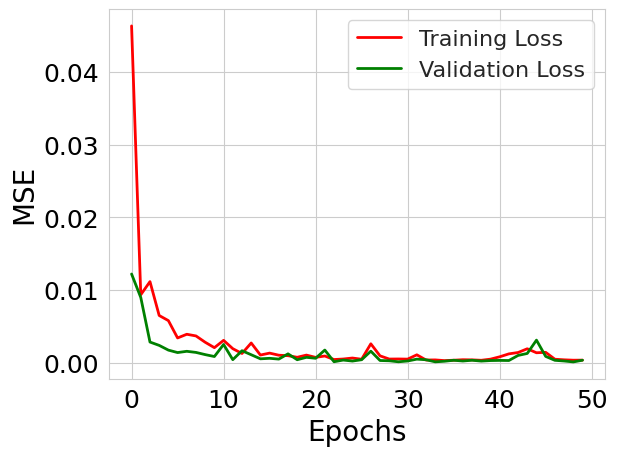

In [62]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20)
plt.tick_params(labelsize=18)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=16)
plt.show()

In [63]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 1s 5ms/step


0.009257736495273346

In [64]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE

0.00034140071699564445

In [65]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse

0.018477032147930155

In [66]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2


-0.0799940421317531

In [67]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)

2.820089671604201

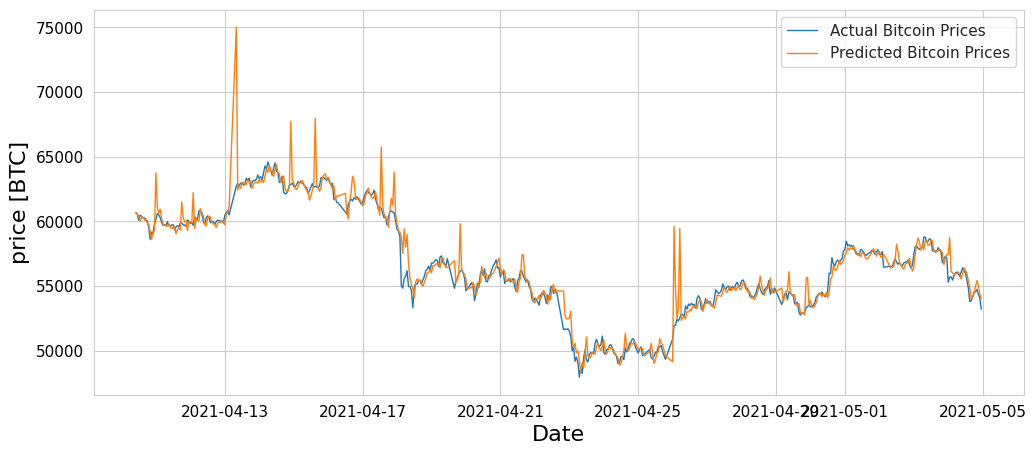

In [68]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=1)

In [69]:
model4_preds=preds

# Hybrid Model



In [70]:
import json
import requests
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Bidirectional, GRU, BatchNormalization
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
get_ipython().run_line_magic('matplotlib', 'inline')

In [71]:
print(tf.__version__)

2.11.0


In [72]:
def build_hybrid_model(input_data, output_size, neurons=100,activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    
    
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2]), return_sequences=True)))
    model.add(Dropout(dropout))
    model.add(Bidirectional(GRU(neurons, return_sequences=False)))
    model.add(Dropout(0.2))
    
    
    model.add(Dense(units=output_size, activation=activ_func))


    model.compile(loss=loss, optimizer=optimizer)
    return model


In [73]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
hybrid_neurons = 256
epochs = 50
batch_size = 8
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [74]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    df2, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [75]:
model = build_hybrid_model(
    X_train, output_size=1, neurons=hybrid_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
281/281 [==============================] - 12s 24ms/step - loss: 0.0283 - val_loss: 0.0045
Epoch 2/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0081 - val_loss: 0.0056
Epoch 3/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0079 - val_loss: 0.0022
Epoch 4/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 5/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0017 - val_loss: 6.7219e-04
Epoch 6/50
281/281 [==============================] - 5s 19ms/step - loss: 9.6004e-04 - val_loss: 3.8134e-04
Epoch 7/50
281/281 [==============================] - 5s 19ms/step - loss: 7.9820e-04 - val_loss: 5.9435e-04
Epoch 8/50
281/281 [==============================] - 5s 19ms/step - loss: 7.2832e-04 - val_loss: 3.9364e-04
Epoch 9/50
281/281 [==============================] - 5s 19ms/step - loss: 0.0011 - val_loss: 3.3798e-04
Epoch 10/50
281/281 [==============================] - 5s 

In [76]:
# Save the model
model.save(path+'hybrid_model.h5')

In [77]:
import pickle

# Assume that 'model' is the trained model
with open(path+'hybrid_model.pkl', 'wb') as f:
    pickle.dump(model, f)


Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......bidirectional
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......bidirectional_1
.........backward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........forward_layer
............cell
...............vars
..................0
..................1
..................2
............vars
.........layer
............cell
...............vars
............vars
.........vars
......dense
.........vars
............0
............1
......dropout
.........vars
......dropout_1
.........vars
...metrics
......mean
.........vars
............0
....

In [78]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 5, 512)           542720    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 5, 512)            0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 512)              1182720   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 1,725,953
Trainable params: 1,725,953
No

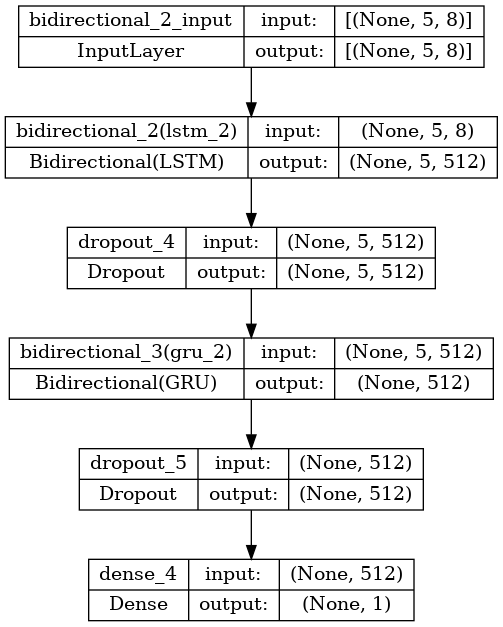

In [79]:
plot_model(model, to_file=path+'hybrid_model.png', show_shapes=True)

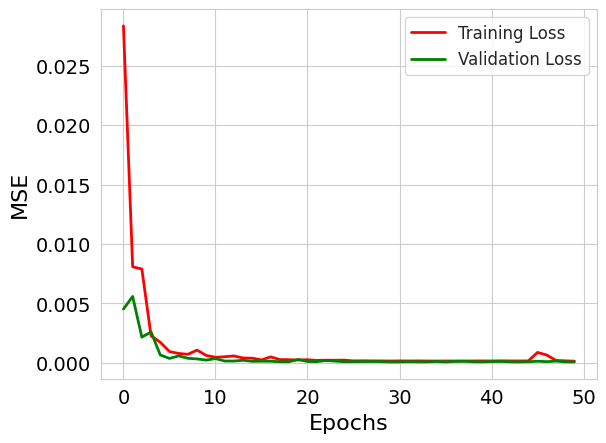

In [80]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
#plt.title('LSTM Model')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('MSE',fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(('Training Loss', 'Validation Loss'),fontsize=12)
plt.show()

In [81]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(y_test, preds)

18/18 [==============================] - 1s 9ms/step


0.006733581851655818

In [82]:
from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE


9.129116057237833e-05

In [83]:
#RMSE
import math
rmse=math.sqrt(MSE)
rmse

0.009554640787197513

In [84]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.7112076670925104

In [85]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, preds)


2.800620561846888

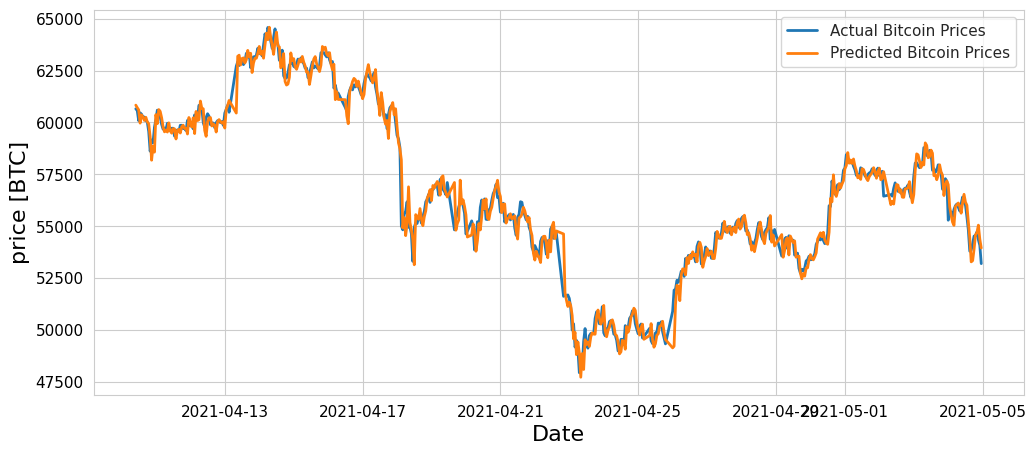

In [86]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Actual Bitcoin Prices', 'Predicted Bitcoin Prices', lw=2)

In [87]:
model5_preds=preds

In [88]:
def line_plot2(line1, line2, line3, line4, line5, line6, label1=None, label2=None, label3=None, label4=None, label5=None, label6=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(15, 6))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.plot(line4, label=label4, linewidth=lw)
    ax.plot(line5, label=label5, linewidth=lw)
    ax.plot(line6, label=label6, linewidth=lw)
    ax.set_ylabel('price [BTC]', fontsize=18)
    ax.set_xlabel('Date', fontsize=18)
    ax.tick_params(labelsize=11)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=11)

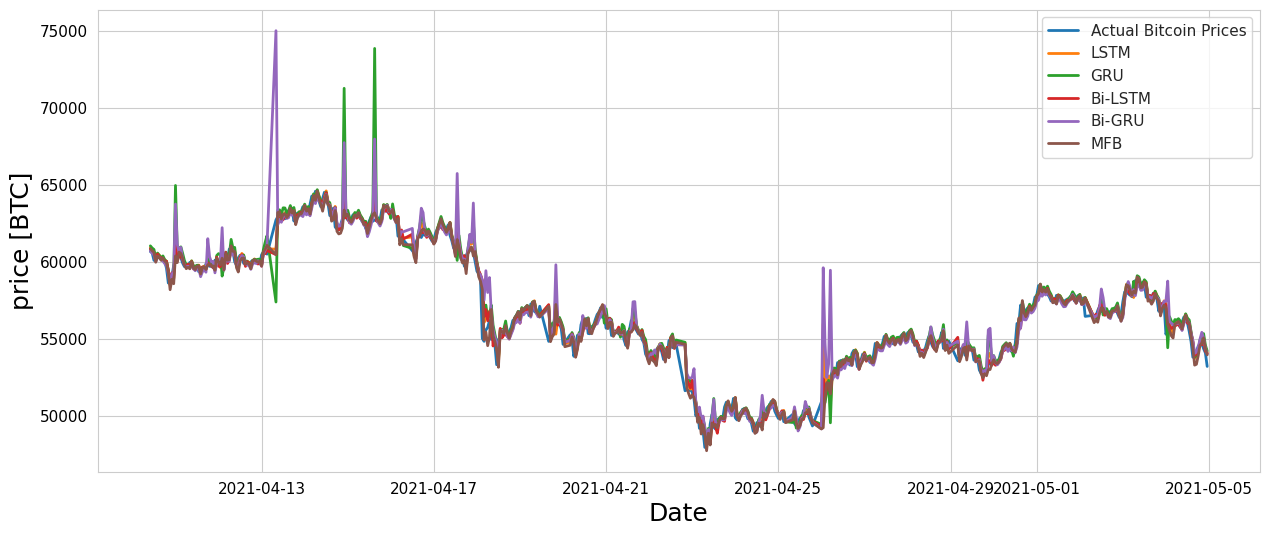

In [89]:
targets = test[target_col][window_len:]
line_plot2(targets, model1_preds, model2_preds, model3_preds, model4_preds, model5_preds, 'Actual Bitcoin Prices', 'LSTM', 'GRU', 'Bi-LSTM', 'Bi-GRU', 'MFB',lw=2)

71/71 [==============================] - 1s 9ms/step


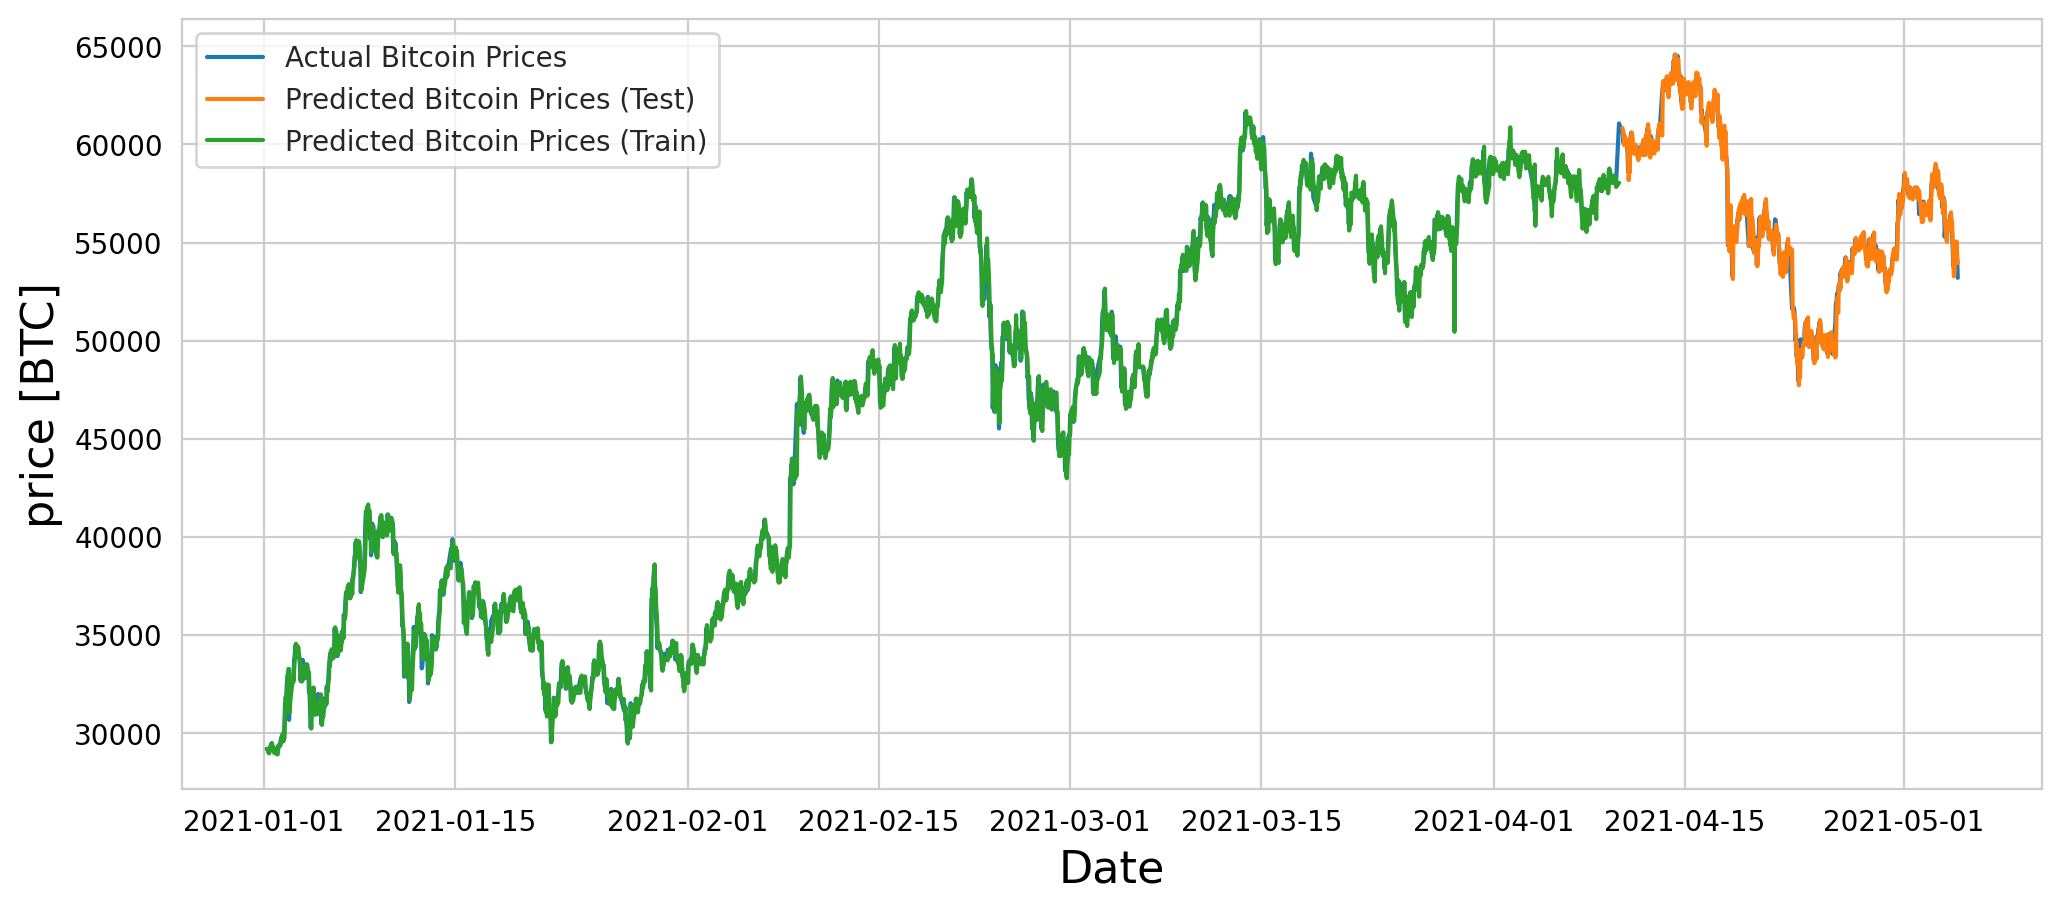

In [90]:
targets = pd.concat([train[target_col][window_len:], test[target_col][window_len:]], axis=0)
# 计算训练集的预测结果
train_preds = model.predict(X_train).squeeze()
# 将预测结果转换为pandas.Series类型，并使用targets的索引和训练集的输出进行归一化还原
train_preds = pd.Series(index=targets.index[:len(train_preds)], data=train_preds.flatten())
train_preds = train[target_col].values[:-window_len] * (train_preds + 1)

# 绘制图形
plt.figure(figsize=(12, 5),dpi=200)  # 设置图形的大小
plt.plot(targets, label='Actual Bitcoin Prices')  # 绘制实际的比特币价格，设置标签
plt.plot(preds, label='Predicted Bitcoin Prices (Test)')  # 绘制测试集的预测结果，设置标签
plt.plot(train_preds,label='Predicted Bitcoin Prices (Train)')  # 绘制训练集的预测结果，设置标签

plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'
plt.tick_params(labelsize=10)
plt.legend(loc='best', fontsize=11);
plt.xlabel('Date', fontsize=16)  # 设置x轴的标签
plt.ylabel('price [BTC]', fontsize=16)  # 设置y轴的标签
plt.legend()  # 显示图例

plt.show()  # 显示图形
